In [1]:
# -*- coding: utf-8 -*-
"""
HVC and Birdsong Covariance Notebook

With this notebook I set out to process population neural 
and birdsong data from Crandall 2007 to produce a graph 
representing the covariance in some mannor.

These data were collected for the following study:

    Crandall, Shane R., Naoya Aoki, and Teresa A. Nick. 
    2007. “Developmental Modulation of the Temporal 
    Relationship Between Brain and Behavior.” Journal 
    of Neurophysiology 97 (1): 806–16. 
    doi:10.1152/jn.00907.2006.

These open data was downloaded from crcns.org, which
contains some additional information on the data.

Features of the audio were produced by processing the
.wav files in the data set with Sound Analysis Pro 2011.

The intention of this notebook was to produce code which
could process the data in such a way that further 
analysis would be simple. Some functions which were used
to save files in difference formats are not included in
order to improve readability.

Created on Mon Jun 29 13:57:37 2015

@author: Alex Brebner
"""

'\nHVC and Birdsong Covariance Notebook\n\nWith this notebook I set out to process population neural \nand birdsong data from Crandall 2007 to produce a graph \nrepresenting the covariance in some mannor.\n\nThese data were collected for the following study:\n\n    Crandall, Shane R., Naoya Aoki, and Teresa A. Nick. \n    2007. \xe2\x80\x9cDevelopmental Modulation of the Temporal \n    Relationship Between Brain and Behavior.\xe2\x80\x9d Journal \n    of Neurophysiology 97 (1): 806\xe2\x80\x9316. \n    doi:10.1152/jn.00907.2006.\n\nThese open data was downloaded from crcns.org, which\ncontains some additional information on the data.\n\nFeatures of the audio were produced by processing the\n.wav files in the data set with Sound Analysis Pro 2011.\n\nThe intention of this notebook was to produce code which\ncould process the data in such a way that further \nanalysis would be simple. Some functions which were used\nto save files in difference formats are not included in\norder to improv

In [2]:
##Imports
import os
import csv
import math

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as sp
from scipy import io
from scipy.io import wavfile as wav
from scipy import signal as sgnp
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy import fftpack
from scipy import stats

import cPickle as pickle
import xlrd

%matplotlib inline

In [45]:
#Constants
sampling_freq = 44100 # sampling rate of the day 2007 data is 44.1 kHz
bird_names = set(['blk161', 'Orange222', 'r87', 'White293']) # names of the adult birds used in Crandall 2007
good_electrodes = {'blk161': ['e2'], 'Orange222': ['e1', 'e2'], 
                   'r87': ['e1', 'e2'], 'White293': ['e2']} # these are the "good electrodes" (RMS >= 3 x baseline RMS)

# work paths, used for working at uni
data_dir = 'C:\\Users\\abre049.UOA\\Documents\\data\\Crandall 2007' 
r87 = 'C:\\Users\\abre049.UOA\\Documents\\data\\Crandall 2007\\r87\\sngr870119wtrig02-Apr135757\\sng162004_0119v4' # for testing purposes before path generator was made
blk161 = 'C:\\Users\\abre049.UOA\\Documents\\data\\Crandall 2007\\blk161\\sngblk1610308wtrigC23-Mar140834\\sng163839_0308v3.mat' # as above
blk161_syl_path = 'C:\\Users\\abre049.UOA\\Documents\\data\\blk161_syll_clust.csv'
blk161_feat_dir = 'C:\\Users\\abre049.UOA\\Documents\\data\\blk161_feature_data'

# home paths, used for wirking at home
# data_dir = 'C:\\Users\\Alex\\Documents\\Crandall2007data'
# blk161 = 'C:\\Users\\Alex\\Documents\\Crandall2007data\\blk161\\sngblk1610308wtrigC23-Mar140834\\sng163839_0308v3.mat'

# the following two constants are dictionaries with paths of data files
syllable_table_path = {'blk161': 'C:\\Users\\abre049.UOA\\Documents\\data\\syllable tables\\blk161.p', 
           'r87': 'C:\\Users\\abre049.UOA\\Documents\\data\\syllable tables\\r87.p', 
           'White293': 'C:\\Users\\abre049.UOA\\Documents\\data\\syllable tables\\White293.p', 
           'Orange222': 'C:\\Users\\abre049.UOA\\Documents\\data\\syllable tables\\Orange222.p'}

feature_table_path = {'blk161': 'C:\\Users\\abre049.UOA\\Documents\\data\\raw feature tables\\blk161\\', 
           'r87': 'C:\\Users\\abre049.UOA\\Documents\\data\\raw feature tables\\r87\\', 
           'White293': 'C:\\Users\\abre049.UOA\\Documents\\data\\raw feature tables\\White293\\', 
           'Orange222': 'C:\\Users\\abre049.UOA\\Documents\\data\\raw feature tables\\Orange222\\'}

# the following is a dictionery used to translate between the name of features as saved by SAP2011 and human readable words, used for plots
feature_name = {'lower_case': {'amplitude': 'amplitude', 'peak_frequency': 'peak freaquency', 'DAS': 'duration of acoustic state', 'am': 'amplitude modulation', 'mean_frequency_amp': 'mean frequency amplitude', 'entropy': 'entropy', 'goodness': 'goodness of pitch', 'pitch': 'pitch', 'mean_frequency': 'mean frequency', 'continuity_t': 'continuity time', 'FM': 'frequency modulation'}, 
               'caps': {'amplitude': 'Amplitude', 'peak_frequency': 'Peak Freaquency', 'DAS': 'Duration of Acoustic State', 'am': 'Amplitude Modulation', 'mean_frequency_amp': 'Mean Frequency Aamplitude', 'entropy': 'Entropy', 'goodness': 'Goodness of Pitch', 'pitch': 'Pitch', 'mean_frequency': 'Mean Frequency', 'continuity_t': 'Continuity Time', 'FM': 'Frequency Modulation'}}



#Load the data location

I want to have a way of feeding the data into python so that I can easy change the scope of data. ie change from single 2-15sec recording to all the data from all birds. 

The data is stored like this: 
Crandall 2007[\__MACOSX[...], bird_name_x[...], bird_name_y[.DS_Store, day_a[...], day_b[wav[...], single_song_data_i, single_song_data_j, ...], ...], ...]

To do this I will make a function which will iterate through all the folders and files and store each subdirectory as dictionary, while ignoring the additional OSX meta-data and wav files. This can then be used to generate the urls of all data files.

This function was used in the initial phases while exploring the data set. Later it was used to generate convert information into file formats which were easier to work with.

In [5]:
def data_file_urls(data_dir):
    """
    Takes the path name of the directory containing bird song data returning a
    a dictionary of all songs.
    
    Parameters:
        data_dir = path name of the directory containing data. Data should be
        from Crandall 2007, downloaded from crcns.org and unzipped into this
        directory
        
    Return object:
        Dictionary where {dir: 'data_dir', bird: {day: set(['song_file.mat'])}}.
        Song file names are stored in unordered sets within a dictionary key of
        days within a dictionary key of bird. The outermost dictionary also 
        contains the directory of the data
    """
    data_urls = {} # dict that will be returned
    
    for bird in os.listdir(data_dir): # finds bird folders
        if bird != '__MACOSX': # ignores metadata for macs
            data_urls[bird] = {}
    for bird in data_urls.iterkeys():
        for day in os.listdir(os.path.join(data_dir, bird)): # finds day folders
            if day != '.DS_Store': # ignore metadata
                data_urls[bird][day] = set(os.listdir(os.path.join(data_dir, bird, day))) # finds files and compiles dictionaries
                data_urls[bird][day].discard('wavs') # ignore wav files
                data_urls[bird][day].discard('.DS_Store')
    data_urls['dir'] = data_dir # remeber the data_dir for easy access later
    return data_urls
    
song_locs = data_file_urls(data_dir) # song_locs is saved as a global variable

# for visualising song_locs
print 'Data directory:', song_locs['dir'], '\n'
print 'Bird folders:', song_locs.keys(), '\n'
print 'Day folders of blk161:', song_locs['blk161'].keys(), '\n'
print 'Song files eg of blk161:', song_locs['blk161']['sngblk1610305wtrig23-Mar120225']

Data directory: C:\Users\abre049.UOA\Documents\data\Crandall 2007 

Bird folders: ['blk161', 'dir', 'Orange222', 'r87', 'White293'] 

Day folders of blk161: ['sngblk1610308wtrigA23-Mar133853', 'sngblk1610308wtrigC23-Mar140834', 'sngblk1610303wtrigA23-Mar110608', 'sngblk1610302wtrig23-Mar104706', 'sngblk1610306wtrigB23-Mar124508', 'sngblk1610309wtrig23-Mar143025', 'sngblk1610306wtrigA23-Mar121557', 'sngblk1610308wtrigB23-Mar134644', 'sngblk1610307wtrigB23-Mar131559', 'sngblk1610305wtrig23-Mar120225', 'sngblk1610307wtrigA23-Mar125009'] 

Song files eg of blk161: set(['sng184151_0305v8.mat', 'sng184151_0305v4.mat', 'sng182330_0305v8.mat', 'sng182122_0305v4.mat', 'sng185025_0305v3.mat'])


#Path generator

Files in the wav format and mat format follow different naming conventions. The following function allows me to translate between the two.

In [6]:
def gen_path(bird, song):
    '''
    Helper function which takes the song file name 
    (as either a .wav or .mat) as named in the
    original data set and the bird name and returns 
    the path of the .mat file
    
    Parameters:
    
        bird - name of the bird as stored in song_locs
        song - name of the song file you want the path for.
            as either .wav or .mat, following the Crandall
            2007 data set naming convensions.
    
    Returns
    
        string with the path name of the file of interest
        
    Exceptions:
    
        'Song name not .wav or .mat'
    '''
    if song[-4:] == '.wav': # account for the different .wav or .mat naming convensions
        file_name = 'sng' + song[6:12] + '_' + song[1:5] + song[12:-4] + '.mat'
    elif song[-4:] == '.mat':
        file_name = song
    else:
        return 'Song name not .wav or .mat'
    for folder in song_locs[bird].keys(): # note needs access to song_locs as a global variable (or at least within the same scope)
#         if folder[9:13] == file_name[10:14]: # identify which 'day' folder the file is in (note some days are split into 2 or 3 folders)
        if file_name in song_locs[bird][folder]:
            folder_name = folder
            break
    return song_locs['dir'] + '\\' + bird + '\\' + folder_name + '\\' + file_name
        
print '.wav eg:', gen_path('blk161', 'v0308t080339v10.wav')
print '.mat eg:', gen_path('blk161', 'sng091922_0308v3.mat')


.wav eg: C:\Users\abre049.UOA\Documents\data\Crandall 2007\blk161\sngblk1610308wtrigA23-Mar133853\sng080339_0308v10.mat
.mat eg: C:\Users\abre049.UOA\Documents\data\Crandall 2007\blk161\sngblk1610308wtrigB23-Mar134644\sng091922_0308v3.mat


#How do the raw data look?

In order to process the data I need to import it into python, and investigate the python objects type and shape.

The python module scipy has a function 'loadmat()' which can read .mat files

I decided to make a convention where data will be loaded outside of helper functions as to conserve memory and for easy of use

Data class:  <type 'dict'>
Keys:  ['sng', 'ref', '__header__', '__globals__', '__version__', 'e1', 'e3', 'e2']
Header:  MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Mar 23 14:28:55 2006
Globals:  []
Versions:  1.0
length of sng array: 164976


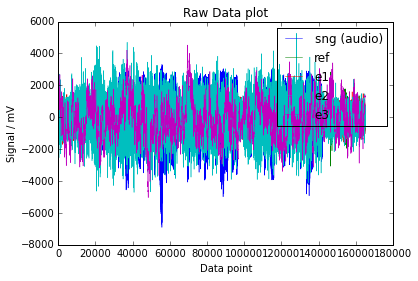

In [7]:
#Workspace
##data_url is now out of date, needs fix
def display_raw_data(data):
    '''
    Takes the data of one song file and prints or plots various information
    to gain an understanding of the object and data shapes
    '''
    print 'Data class: ', type(data) # what is the python data type?
    print 'Keys: ', data.keys()
    print 'Header: ', data['__header__']
    print 'Globals: ', data['__globals__']
    print 'Versions: ', data['__version__']
    print 'length of sng array:', len(data['sng']) # need to plot this as so long

    plt.plot(data['sng'], label='sng (audio)', linewidth=0.5)
    plt.plot(data['ref'][0], label='ref', linewidth=0.5)
    plt.plot(data['e1'][0], label='e1', linewidth=0.5)
    plt.plot(data['e2'][0], label='e2', linewidth=0.5)
    plt.plot(data['e3'][0], label='e3', linewidth=0.5)
    plt.legend()
    plt.title('Raw Data plot')
    plt.ylabel('Signal / mV')
    plt.xlabel('Data point')

display_raw_data(sp.io.loadmat(gen_path('blk161', 'sng163839_0308v3.mat'))) # load the data in the argument area.

#Listen to audio

To insure that the 'sng' array in the data are indeed songs I need to export them as a .wav file and listen to them. I will also need to subjectively compare these to the .wav file provided to insure they are indded of the same rendition.

scipy has a function to export .wav files

The raw data do indeed match the .wav files as compared by ear on multiple files

In [70]:
def make_wav_file(data):
    '''
    Takes a loaded .mat file and generates a .wav file from the raw audio data named audio.wav in the working directory
    '''
    sp.wavfile.write('audio.wav', sampling_freq, data)
    
song_data = sp.io.loadmat(gen_path('blk161', 'sng163839_0308v3.mat'))['sng']
# make_wav_file(sp.io.loadmat(song_data))

#What does one population electrode look like?

According to the study paper each bird had data recorded form a reference electrode, a eeg electrode and either one or two HVC electrodes.

According to the data description there is data for electodes called 'ref', 'e1', 'e2', 'e3'. According to the description e2 was "good" for all birds and o222 and w293 had "good" e1 electrodes. When plotted all the the e electrodes always has some signal however in blk161 and w293 the 'e1' had a homogenous signal. 'e3' had a significanlty different shape than the other 3 electrode recordings. 

My conclusion is that:
ref: reference electrode
e1: hvc electrode from o222 and w293, noise from the other two birds
e2: hvc electrodes from all birds
e3: eeg electrodes

In order to get a cleaner signal the difference of the recording electrode and reference electrode should be taken.

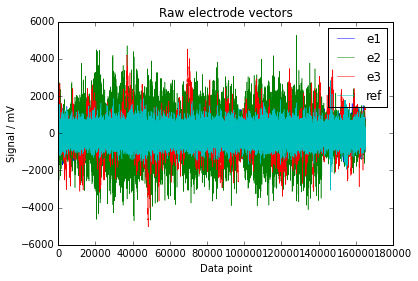

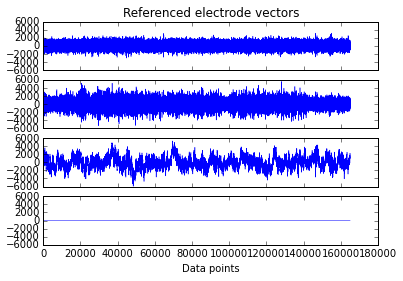

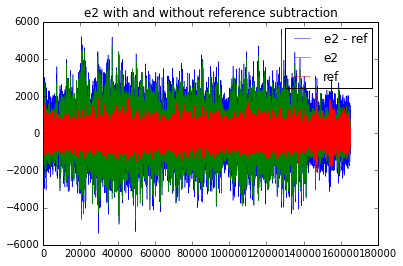

In [8]:
def ref_e(data, electrode='e2'):
    '''
    Returns the difference of the specified electrode and the reference electrode. Defaults to e2.
    Parameters:
        data = python dict of .mat data
        electrode = string of the desired electrode
        
    Return:
        1d np.array of refferenced electrode data
    '''
    return np.array(data[electrode][0]) - np.array(data['ref'][0])

def plot_electrode(data):
    '''
    takes the loaded .mat file of a song and plots raw electrode vectors, 
    referenced electrode vectors and and example of electrode data before 
    and after referencing
    
    Parameters:
        data = dict of sp.io.loadmat generated .mat data of one bird song recording
    '''
    
    plt.plot(data['e1'][0], label='e1', linewidth=0.5)
    plt.plot(data['e2'][0], label='e2', linewidth=0.5)
    plt.plot(data['e3'][0], label='e3', linewidth=0.5)
    plt.plot(data['ref'][0], label='ref', linewidth=0.5)
    plt.legend()
    plt.title('Raw electrode vectors')
    plt.ylabel('Signal / mV')
    plt.xlabel('Data point')
    plt.show()
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
    ax1.plot(ref_e(data, electrode='e1'), label='e1', linewidth=0.5)
    ax1.set_title('Referenced electrode vectors')
    ax2.plot(ref_e(data, electrode='e2'), label='e2', linewidth=0.5)
    ax3.plot(ref_e(data, electrode='e3'), label='e3', linewidth=0.5)
    ax4.plot(ref_e(data, electrode='ref'), label='ref', linewidth=0.5)
    ax4.set_xlabel('Data points')
    plt.show()
    
    plt.plot(ref_e(data, electrode='e2'), label='e2 - ref', linewidth=0.5)
    plt.plot(data['e2'][0], label='e2', linewidth=0.5)
#     plt.plot(ref_e(data, electrode='e2'), label='e2 - ref', linewidth=0.5)
    plt.plot(data['ref'][0], label='ref', linewidth=0.5)
    plt.title('e2 with and without reference subtraction')
    plt.legend()
    plt.show()

song_data = sp.io.loadmat(gen_path('blk161', 'sng163839_0308v3.mat'))
plot_electrode(song_data)


#Plot song

What does the raw bird song look like?

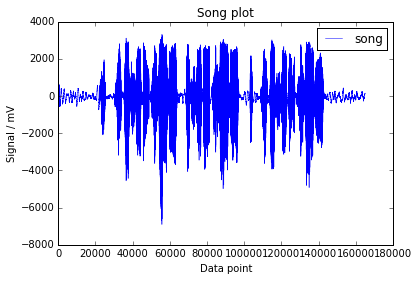

In [9]:
def plot_song(data, lw=0.5, plot_now=False):
    '''
    Takes raw song data and plots the raw audio component
    
    Parameters:
        data - sp.io.loadmat genereated dict of .mat file of raw song
        lw - line width
        plot_now - boolean. default is False which does not plt.show() so that other plots can be put on the same graph.
            True will plt.show() with labels
            
    Return: Nil
    '''
    plt.plot(data['sng'], label='song', linewidth=lw)
    if plot_now:
        plt.legend()
        plt.title('Song plot')
        plt.ylabel('Signal / mV')
        plt.xlabel('Data point')
        plt.show()
    
plot_song(sp.io.loadmat(gen_path('blk161', 'sng163839_0308v3.mat')), plot_now=True)

#Plot spectrogram

What does the spectrogram of a raw song look like?

Also, we were curious what the spectrogram of the neural population data would look like. We wondered if we would be able to identify patterns in the spectrogram which would represent specific neuron types (given that neuron types have unique action potential patterns.

processing ideas: plot in grayscale. print and view paper horizontally. cut frequencies > ~ 5000. plot log y axis. filter signal before fft.

The electrode spectrogram idea was moved to a different file and eventually dropped as a line of investigation for this project.

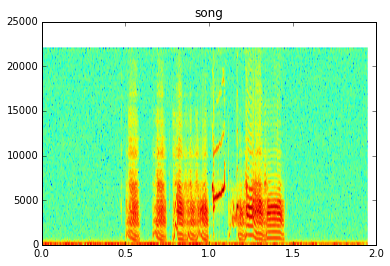

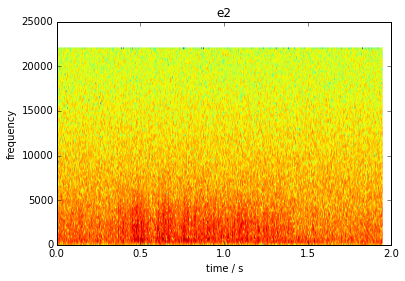

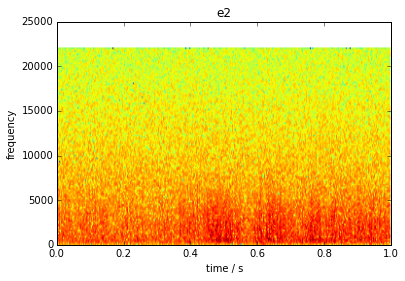

In [10]:
def plot_spectrogram(data):
    '''
    Takes raw data and plots raw specgram using matplotlib
    
    Parameters:
        data = raw data in the form of a dict from sp.io.loadmat of .mat song file
    '''
    one_d_data = [idx[0] for idx in data]
    plt.specgram(one_d_data, Fs=sampling_freq)
    
# v0307t072941v2.wav
# sng163839_0308v3.mat
def electrode_specgram():
    song_data = sp.io.loadmat(gen_path('blk161', 'v0307t072941v2.wav'))
    plot_spectrogram(song_data['sng'])
    plt.title("song")
    plt.show()

    plt.specgram(ref_e(song_data, electrode='e2'), Fs=sampling_freq)
    plt.title("e2")
    plt.ylabel('frequency')
    plt.xlabel('time / s')
    plt.show()

    plt.specgram(ref_e(song_data, electrode='e2')[:44100], Fs=sampling_freq)
    plt.title("e2")
    plt.ylabel('frequency')
    plt.xlabel('time / s')
    plt.show()
    
electrode_specgram()

#Import syllable data

SAP2011 was used to generate song features from the .wav files provided in the data set. A syllable was defined as continuous sound > 40 db amplitude. Syllables were manually checked to exclude noise. Only syllables with at least two preceeding introductory notes were chosen for bird blk161. Zebra finch default settings were used. Syllables were then clustered with SAP2011. These were exported with the backup function (as the export function was not working at the time) and the backup file was manually changed from .xls to .csv.

update. syllable tables are now in pickle file format in a list of dictionaries with the keys:
'max_peak_freq', 'mean_mean_frequency', 'max_continuity_t', 'max_entropy', 'max_FM', 'min_DAS', 'var_pitch', 'mean_continuity_t', 'file_name', 'min_meanFr', 'var_entropy', 'min_pitch', 'max_meanFr', 'cluster', 'start_on', 'min_FM', 'duration', 'mean_goodness_of_pitch', 'mean_peak_freq', 'mean_DAS', 'mean_continuity_f', 'var_goodness_of_pitch', 'max_amplitude', 'mean_pitch', 'max_pitch', 'mean_entropy', 'max_DAS', 'var_am', 'max_continuity_f', 'mean_FM', 'var_FM', 'min_entropy', 'var_mean_frequency', 'serial_number', 'min_peak_freq', 'mean_am2', 'mean_amplitude'

The code was used for inital coding. Eventually it was copied into several different notebooks and modified in order to convert data from .csv format to .p format for faster processing.

In [16]:
def get_syl_data(syll_data_path):
    '''
    Takes the directories of the .cvs file with syllable data and cluster number (produced with SAP2011 backup function).
    Return a 2d list with data
    Parameters:
        syll_data_path - a directory containing the .cvs file produced by SAP2011 backup function
            with cols of song_name, start time, duration, mean_freq etc
    Returns:
        list of lists. first row contains the headings of the columns as strings. The remaining lists are the data as either
            strings or floats
    Exceptions: nil
    '''
    syl_data = [] # the return object
    with open(syll_data_path, 'r') as f: # opens the .csv file
        reader = csv.reader(f)
        headings = [] # will become the first row
        row_data = [] # used to make the table body
        row_numb = 0 # counter to keep track of which row as some data must be excluded as it is garbage
        for row in reader: # iterates through the .csv rows
            if row_numb >= 16 and row_numb < 61: # these row contain the heading information
                char_state = 0 # there is garbage characters around the useful information, this keeps track of the useful info
                col_head = ''
                for char in row[0]:
                    if char == "`": # data between the first two ` is the useful information
                        char_state += 1
                    elif char_state == 1: # only use useful info
                        col_head += char
                headings.append(col_head)
            elif row_numb == 61: # there are a few blank rows, use the first one to assign the headings into syl_data
                syl_data.append(headings)
            elif row_numb >= 70 and len(row) > 1: # identify the data body, ignoring empty rows
                for val in row: # cleans the data as there are useless chars arond the useful info
                    if val[0:3] == "  (":
                        row_data.append(float(val[3:])) #convert the numbers from strings to floats
                    elif val[:2] == " '":
                        row_data.append(val[2:-1]) # some info are strings
                    elif len(val) > 0:
                        row_data.append(float(val[1:])) # convert the numbers from strings to floats
            if len(row_data) > 0: # don't add empty rows to data
                syl_data.append(row_data)
            row_numb += 1
            row_data = []
        f.close()
    return syl_data

# syl_data = {}
# for bird in bird_names:
#     syl_data[bird] = get_syl_data(syllable_table_path[bird])
# print syl_data['blk161']


    

#Do the same for file table

The below code will need to be combinded with the raw_feature_table in order to identify the correct song.

update. this has been done. All relevant info is now contained in pickles files for each bird as a dict of dicts such that:

bird.p --> {'song_name.wav':{'feature_name': int}}

When the data files were converted to .p files this function became redundant. It is left here for demonstration purposes only as the file converting functions are not contained within this notebook.

In [17]:
def get_file_table(bird, file_table_path='C:\\Users\\abre049.UOA\\Documents\\data\\file tables'):
    '''
    This function take a bird name and the file path to a SAP2011 made (backup) .csv file of the file table.
    It returns a dictionary of the file table in the format:
    
    {'song_name.wav': feature_table_index}
    '''
    file_path = file_table_path + '\\' + bird + '.csv'
    file_table_data = {} # the return object
    with open(file_path, 'r') as f: # opens the .csv file
            reader = csv.reader(f)
            row_numb = 0 # counter to keep track of which row as some data must be excluded as it is garbage
            for row in reader: # iterates through the .csv rows
                if row_numb >= 29 and len(row) > 1: # identify the data body, ignoring empty rows
                    for val in row[1:3]: # cleans the data as there are useless chars arond the useful info
                        if val[:2] == " '":
                            file_name = val[2:-1] # some info are strings
                        elif len(val) > 0:
                            file_index = int(val[1:]) # convert the numbers from strings to floats
                    file_table_data[file_name] = file_index
                row_numb += 1
            f.close()
    return file_table_data

file_table = {}
for bird in bird_names:
    file_table[bird] = get_file_table(bird)
print file_table.keys()
print file_table['Orange222']['v0417t174548v2.wav']

['blk161', 'Orange222', 'r87', 'White293']
107


#Import song feature arrays

Using SAP2011 the feature arrays were generated from the .wav files, with filters of 500 - 8000Hz and window of 1ms. Arrays were manually copy and pasted into an excel sheet (one for each syllable) and saved as an .csv file. features include 'Goodness_of_pitch', 'Wiener_entropy', 'Peak_frequency', 'Time', 'AM', 'Continuity_freq', 'Continuity_time', 'Amplitude', 'Pitch', 'Mean_frequency', 'Duration_of_state', 'FM'. Note that each file covers an entire motif and syllables must be identified by the time specefied in the syllable table.

This function has been superseeded by the raw_feature_tables in the pickle file format. This was done to easily move between birds and so that the raw_feature_table cauculations could be automated by SAP2011.

This function followed the same fate as get_file_table.

In [19]:
def get_song_feat(path):
    '''
    Takes the path of .csv file produced by SAP2011 with the backup function which contains the set of arrays of song features
    Returns a dicitonary where keys are the feature name and values are a list of plots.
    Parameters:
        path of feature_table.csv
    Return:
        dict where {'song feature': [values]}.
    Exceptions:
        nil
    '''
    feat_arrays = {}
    with open(path, 'r') as f:
        reader = csv.reader(f)
        row_numb = 0
        dict_body = []
        for row in reader:
            if row_numb == 0:
                headings = row
                for en in headings:
                    dict_body.append([])
            elif row_numb > 1: # skip row two which is blank
                for idx in range(len(row)):
                    dict_body[idx].append(float(row[idx]))
            row_numb += 1
        f.close()
    for idx in range(len(headings)):
        feat_arrays[headings[idx]] = dict_body[idx]
    return feat_arrays
    
# testing = get_song_feat(blk161_feat_dir + '\\v0307t072941v2.csv')
# for y in testing:
#     if y != 'Time':
#         plt.plot(testing['Time'], testing[y], label=y)
# plt.legend()
# plt.show()
# plt.plot(testing['Amplitude'])
# plt.show()

testing = get_song_feat(blk161_feat_dir + '\\v0307t072941v2.csv')
print 'Column headings: ', testing.keys()


Column headings:  ['Goodness_of_pitch', 'Wiener_entropy', 'Peak_frequency', 'Time', 'AM', 'Continuity_freq', 'Continuity_time', 'Amplitude', 'Pitch', 'Mean_frequency', 'Duration_of_state', 'FM']


#Extract and align feature arrays to match syllable time

I needed to extract the feature arrays corresponding to each syllable and then centre them so that the centre of each syllable is aligned to 0. it was felt that aligning midpoints was the best way to align syllables as it skews the data less than alignment from the start or end and is technically easier than aligning by highest correlation.

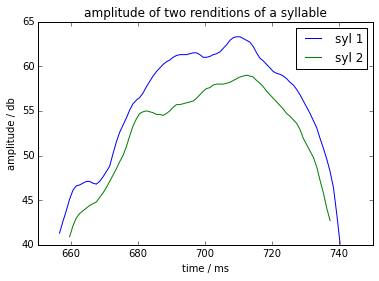

In [22]:
def cut_array(array_times, array_vals, start_time, duration):
    '''
    Take and array for the time axis and feature value axis 
    as well as the start time and duration of a syllable and 
    extracts the appropriate segment of array values returning 
    the time and values as a tuple
    
    Parameters:
        array_times - list of the time axis of a song feature
        array_vals - list of the song feature values
        start_time - the first time to extract
        duration - length of syllable
    
    Return:
        Tuple containing two list, first being the time values, 
        second being the syallable values of one syllable
    
    '''
    start_idx = 0
    stop_idx = 0
    for idx in range(len(array_times)):
        if array_times[idx] <= start_time - 0.1: # note that because the values to not match exactly the selection is rounded down to the hundreth of a microsecond
            start_idx = idx
        elif array_times[idx] <= start_time + duration - 1:# note that because the values to not match exactly the selection is rounded up
            stop_idx = idx
    return array_times[start_idx: stop_idx], array_vals[start_idx: stop_idx]
            
syl_data = get_syl_data(blk161_syl_path)
feat_data = get_song_feat(blk161_feat_dir + "\\" + syl_data[1][-2][:-3] + 'csv')
x_vals, y_vals = cut_array(feat_data['Time'], feat_data['Amplitude'], syl_data[1][3], syl_data[1][4])
plt.plot(x_vals, y_vals, label='syl 1')
feat_data = get_song_feat(blk161_feat_dir + "\\" + syl_data[5][-2][0:-3] + 'csv')
x_vals, y_vals = cut_array(feat_data['Time'], feat_data['Amplitude'], syl_data[5][3], syl_data[5][4])
plt.plot(x_vals, y_vals, label='syl 2')
plt.title('amplitude of two renditions of a syllable')
plt.legend()
plt.xlabel('time / ms')
plt.ylabel('amplitude / db')
plt.show()


#Center x values

We decided to align syllables by the center point. The reasoning behind this method is that it is simple and more intuative to interpret. There are obvious limitation to this method in that due to the arbritrary nature of syllable definition (is greater then 40db, and the potential for syllables to be lengthened by backround noise or shorteded by birds facing away from the speakers The alignment will not be perfect. An alternative way of alignment could be aligning by largest correlation.

In [23]:
def center_x(x_vals, units='ms'):
    '''
    takes an array of time or sample values and aligns the 
    middle value to 0. assumes uniform distribution. If 
    samples are given the output value is converted to ms
    
    Parameters:
        x_vals - a list containing either time values in ms or sample number corresponding to a syllable array
        units - string either 'ms' or 'samples' denoting the unit of x_vals, default to 'ms'
    
    Return:
        list with time values centered to zero
        
    Exceptions:
        'invalid argument for units, need "ms" or "samples"'
    '''
    new_x = []
    left_shift = float(min(x_vals)) + ((max(x_vals) - min(x_vals)) * 0.5) # how far to move left
    if units=='samples':
        for val in x_vals:
            new_x.append((val - left_shift) / sampling_freq * 0.001) # converts to ms
    elif units == 'ms':
        for val in x_vals:
            new_x.append(val - left_shift)
    else:
        return 'invalid argument for units, need "ms" or "samples"'
    return new_x
        
print center_x([1,2,3,4,5])

[-2.0, -1.0, 0.0, 1.0, 2.0]


#Plot a feature of a cluster

In order to test all the preceeding code I decided to try to plot a feature (amplitude) of all the clusters of a song. This would be a good test most of the previous code. I decided to combine this code with a function that could make a list of a feature of all the syllables in a cluster. 

I decided to make this function a generator to conserve memory.

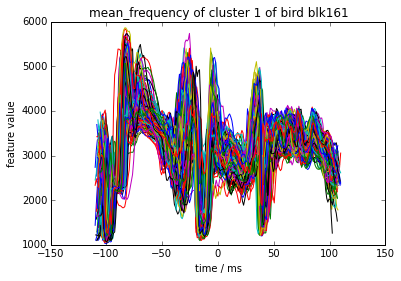

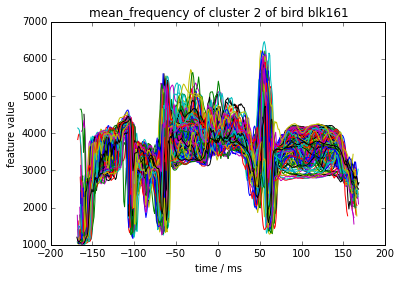

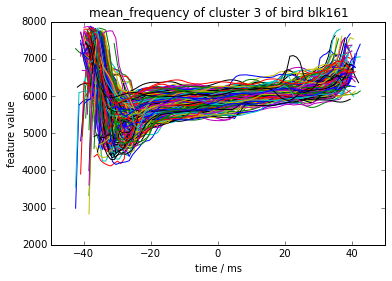

In [28]:
def clust_gen(bird, clust_num, feature, plot=False):
    '''
    Generator returning a 2d list of centered x and y vals of the feature for the cluster specified. 
    Can also plot arrays.
    
    Parameters:
        syl_path - string, path to the syllable table of a bird
        clust_num - iteger, cluster number as generated by SAP2011
        feature - string, heading of feature of interest as per feature table from SAP2011
        feat_dir - directory folder for the feature .csv files
        plot - boolean, default to False, True will plot the arrays
    
    Returns:
        Generator yielding:
            3d list, idx_0 is a list with the centered time values, 
            idx_1 is a list with the corresponding feature values 
            and idx_3 is a integer of the idx of the syllable in the cluster
    '''
    sylls = []
    syl_table = pickle.load(open(syllable_table_path[bird], 'rb')) # open the syllable_table
    for idx in range(len(syl_table)): # learn which syllables are in the desired cluster
        if syl_table[idx]['cluster'] == clust_num:
            sylls.append(idx)
    for idx in sylls:
        song_name = syl_table[idx]['file_name'][:-3]
        feat_table = pickle.load(open(feature_table_path[bird]+song_name+'p', "rb"))
        x_vals, y_vals = cut_array(range(len(feat_table['amplitude'])), feat_table[feature], syl_table[idx]['start_on'], syl_table[idx]['duration']) # extract array of that syllable from feature data
        x_vals = center_x(x_vals)
        yield [x_vals, y_vals, idx]
        if plot:
            plt.plot(x_vals, y_vals)
    if plot:
        plt.title(feature + ' of cluster ' + str(clust_num) + ' of bird ' + bird)
        plt.xlabel('time / ms')
        plt.ylabel('feature value')

        
for bird in ['blk161']:
    for cluster in range(1, 4):
        x = []
        y = []
        syllable_table_index = []
        for temp_x, temp_y, temp_idx in clust_gen(bird, cluster, 'mean_frequency', plot=True):
            x.append(temp_x)
            y.append(temp_y)
            syllable_table_index.append(temp_idx)  
        plt.show()

The below code was used for debugging and is left in as a reminder. There was an issue with unexpected traces in the cluster. this turn out to be two bugs, the first was SAP2011 sometimes replaces a ',' with a ';' in the .csv files which affected my reading of the file name.

The second was that the SAP2011 clustering was not behaving as I expected. I reclustered all the syllables.

In [81]:
# bad_eggs = []
# for idx in range(len(y)):
#     if min(y[idx]) < 17:
#         bad_eggs.append(idx)
        
# print bad_eggs


# for val in bad_eggs:
#     plt.plot(y[val])
        
# plt.show()

# syl_table = pickle.load(open(syllable_table_path['blk161'], 'rb'))
# bad_egg_names = []
# for val in bad_eggs:
#     bad_egg_names.append(syl_table[val]['file_name'])
    
# print bad_egg_names

# song_name = bad_egg_names[0]
# plt.plot(y[bad_eggs[0]])
# feat_table = pickle.load(open(feature_table_path['blk161']+song_name[:-3]+'p', "rb"))
# plt.plot(feat_table['amplitude'])
# plt.show()
    
# for song_name in bad_egg_names:
#     feat_table = pickle.load(open(feature_table_path['blk161']+song_name[:-3]+'p', "rb"))
#     plt.plot(feat_table['amplitude'])
#     plt.show()
    
#     for song in syl_table:
#         if song['file_name'] == song_name and song['cluster'] == 1:
#             print 's', song['start_on']
#             print 'd', song['duration']

#Match X values to median

In order to compare the values of each feature I needed to either use windows or interpolate to match x values. This second technique had the advantage of cutting the longer arrays to the shortest array so that a correlation coefficent could be generated. Windows had the disadvantage of sometimes including syllables twice in one window (due to rounding errors from previous processing). Therefore I chose to interpolate to match x values.

In [29]:
def shortest_array(x_arrays):
    '''
    Function to be used in conjunction with match_x. Returns the the shortest list in a list of lists
    '''
    shortest_idx = -1
    shortest_val = 999999999999.9
    for idx in range(len(x_arrays)):
        if x_arrays[idx][-1] < shortest_val:
            shortest_idx = idx
            shortest_val = x_arrays[idx][-1]
    return x_arrays[shortest_idx]

old x len 205 , first val -102.0 , last val 102.0
new x len 200 , first val -99.5 , last val 99.5


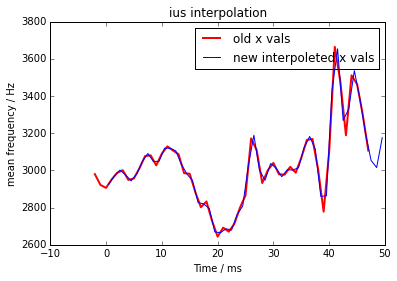

In [31]:
def match_x(ref_x, x_array, y_array):
    '''
    uses InterpolatedUnivariateSpline to match the x values (time) of an array with that of another shorter array.
    
    Parameters:
        ref_x - list, x values to map to
        x_array - list, x values of original graph
        y_array - list, y values of original graph
    
    Return:
        list of new y values matched to the ref_x values
    '''
    temp = ius(x_array, y_array) # ius may not be appropriate, but looks like it does a good job
    new_y = temp(ref_x)
    return new_y
    
x = []
y = []
for temp_x, temp_y, temp_idx in clust_gen('blk161', 1, 'mean_frequency', plot=False):
    x.append(temp_x)
    y.append(temp_y)
y_vals =  match_x(shortest_array(x), x[0], y[0]) # can use shortest_array() as an argument
print 'old x len', len(x[0]), ', first val', x[0][0], ', last val', x[0][-1]
print 'new x len', len(shortest_array(x)), ', first val', shortest_array(x)[0], ', last val', shortest_array(x)[-1]
plt.plot(x[0][100:150], y[0][100:150], color='r', label='old x vals', linewidth='2.0')
plt.plot(shortest_array(x)[100:150], y_vals[100:150], label='new interpoleted x vals')
plt.legend()
plt.title('ius interpolation')
plt.xlabel('Time / ms')
plt.ylabel('mean frequency / Hz')
plt.show()

#Make median array

In order to quantify the variation of a song feature I needed to create an "average" waveform. The average can be either mean of median.

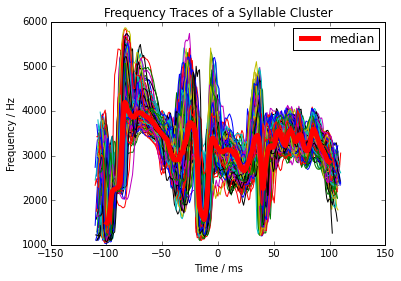

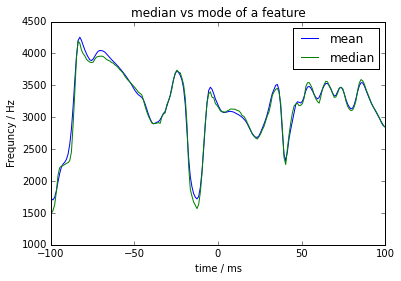

In [33]:
def make_median_array(x_array, y_arrays, average='median'):
    '''
    Takes list of lists with respective x and y values of a 
    graph and finds the median (or mode) of y value at each x value. 
    Arrays must be of the same length and value (ie interpolated)
    
    Parameters:
        x_array - 1d list, the x values (time) of all the different y value arrays
        y_array - 2d list, each sub list are the values (floats) for a feature of one syllable
        average - string, either 'median' or 'mode. default is 'median'
    
    Return:
        np.array object of the "average" y values
    '''
    median_y = []
    for idx in range(len(x_array)):
        y_vals = []
        for array in y_arrays:
            y_vals.append(array[idx])
        if average == 'median':
            median_y.append(np.median(y_vals))
        elif average == 'mean':
            median_y.append(np.mean(y_vals))
    return median_y
    
x = []
y = []
for temp_x, temp_y, temp_idx in clust_gen('blk161', 1, 'mean_frequency', plot=True):
    x.append(temp_x)
    y.append(temp_y)
shortest_x_array = shortest_array(x)
for idx in range(len(x)):
    y[idx] = match_x(shortest_x_array, x[idx], y[idx])
median_y = make_median_array(shortest_x_array, y, average='median')
plt.plot(shortest_x_array, median_y, label='median', linewidth='5.0', color='r') # plot median on the clusters
plt.title('Frequency Traces of a Syllable Cluster')
plt.xlabel('Time / ms')
plt.ylabel('Frequency / Hz')
plt.legend()
plt.show()

foo = make_median_array(shortest_x_array, y, average='mean') # plot median vs mean for comparison
bar = make_median_array(shortest_x_array, y, average='median')
plt.plot(shortest_x_array, foo, label='mean')
plt.plot(shortest_x_array, bar, label='median')
plt.legend()
plt.title('median vs mode of a feature')
plt.xlabel('time / ms')
plt.ylabel('Frequncy / Hz')
plt.show()

#Quantify varience

NumPy has a function called corrcoef which is able to calculate the pearsons correlation between two arrays.

0.906994722066
0.923024899898
0.883576302438
:)


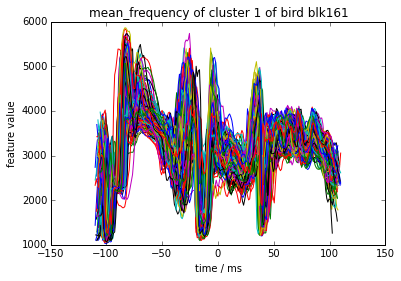

In [35]:
def calc_corr(ref, array):
    return np.corrcoef([ref, array])[0][1]

x = []
y = []
for temp_x, temp_y, temp_idx in clust_gen('blk161', 1, 'mean_frequency', plot=True):
    x.append(temp_x)
    y.append(temp_y)
shortest_x_array = shortest_array(x)
for idx in range(len(x)):
    y[idx] = match_x(shortest_x_array, x[idx], y[idx])
median_y = make_median_array(shortest_x_array, y, average='median')
print calc_corr(median_y, y[0])
print calc_corr(median_y, y[1])
print calc_corr(median_y, y[2])
print ":)"

corr_coefs = []
for y_vals in y:
    corr_coefs.append(calc_corr(median_y, y_vals))

#Savitzky-Golay smoothing filter

Day 2008 paper specifies that they used the following filter:

Savitzky-Golay smoothing filter with 4th order polynomial fit and 50 ms frame size

I will try to implement this with the SciPy.Signal module. This filter will hopefull give me a nice amplitude envelope for the electrode data. 

C:\Users\abre049.UOA\AppData\Local\Continuum\Anaconda\lib\site-packages\scipy\signal\_savitzky_golay.py:130: RuntimeWarning: invalid value encountered in power
  A = x ** order


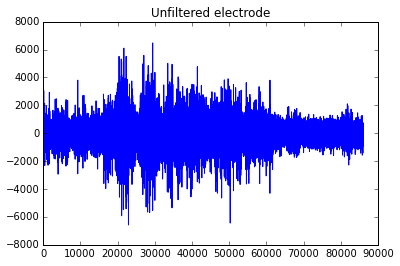

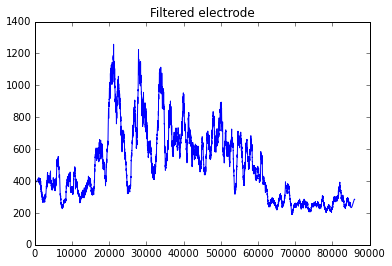

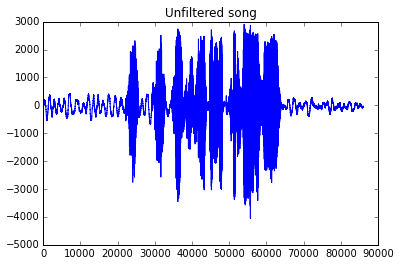

<function matplotlib.pyplot.show>

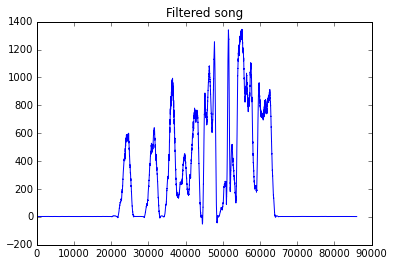

In [36]:
def signal_filter(array, data_type):
    '''
    Filters signals as per the Day 2008 processing. That is applied a band-pass butterworth filter, 
    rectifier and Savitzky-Golay filter in order to obtain amplitude envelopes from signals.
    
    For electrode signals band-pass = 300-6000 Hz, Savitzky-Golay filter frame = 50 ms
    For audio signals band=pass = 1000-8000Hz, Savitzky-Golay filter frame = 20 ms
    
    Savitzky-Golay filters are 4th order.
    
    Parameters:
        array - list, y-values to be filtered
        data_type - string, "e" = electrode, "sng" = song
        
    Return:
        np.array - filtered data
    '''
    nyquist = sampling_freq / 2.0
    if data_type == 'e': # e stands for electrode ie the neuronal data
        b, a = sgnp.butter(1, [300/nyquist, 6000/nyquist], btype='bandpass')
        filtrate = sgnp.filtfilt(b, a, array)
        filtrate = abs(filtrate)
        window = int(50 * sampling_freq * 0.001)
        if window%2 == 0:
            window += 1
        filtrate = sgnp.savgol_filter(filtrate, window, 4, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
        return filtrate
    
    elif data_type == 'sng': # sng stands for song ie audio data
        b, a = sgnp.butter(1, [1000 / nyquist, 8000 / nyquist], btype='bandpass')
        filtrate = sgnp.filtfilt(b, a, array)
        filtrate = abs(filtrate)
        window = int(20 * sampling_freq * 0.001)
        if window%2 == 0:
            window += 1
        filtrate = sgnp.savgol_filter(filtrate, window, 4, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
        return filtrate

y = sp.io.loadmat(gen_path('blk161', syl_data[1][-2]))['e2'][0]
filtrate = signal_filter(y, 'e')
plt.plot(y)
plt.title('Unfiltered electrode')
plt.show()
plt.plot(filtrate)
plt.title('Filtered electrode')
plt.show()

temp_y = sp.io.loadmat(gen_path('blk161', syl_data[1][-2]))['sng']
y = [val[0] for val in temp_y]
filtrate = signal_filter(y, 'sng')
plt.plot(y)
plt.title('Unfiltered song')
plt.show()
plt.plot(filtrate)
plt.title('Filtered song')
plt.show

#Do the same for electrodes

#Extract electrode data

I needed to exctract the electrode data that preceeded the audio by a specified time. Typically this delay is reported at 50ms so this will be the default value.

It was found that some electrode (~30%) traces were failed recordings, presumably due to faulty connections and the bird moving. These syllables were removed from analysis.

v0307t072941v2.wav 1008.71 81.8141
14345 14345


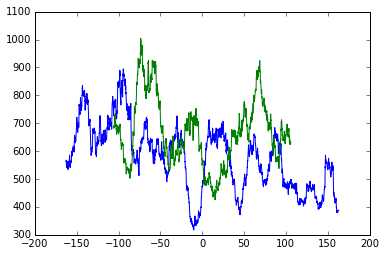

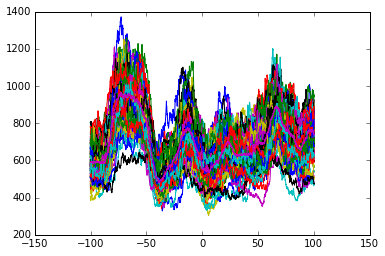

0.937412758697


In [37]:
def get_elec_data(song_data, syl_start, syl_dur, offset=50, electrode='e2'):
    '''
    This function takes data from an opened matlab file, the start and end time of the desired 
    syllable and extracts the electrode data preceeding it up 50ms.
    the delay can be set manually with the argument 'offset' which takes is the desired delay in ms
    the argument 'electrode' is used to change the electrode data returned. options are e1, e2 or e3
    
    returns a tuple of arrays, the first are the x time, the second the corresponding electrode recording values
    '''
    first_sample = int((syl_start - offset) * sampling_freq * 0.001)
    last_sample = int((syl_start + syl_dur - offset) * sampling_freq * 0.001)
    
    e_data = np.array(song_data[electrode][0])
    ref_data = np.array(song_data['ref'][0])
#     e_data = e_data - ref_data
    filtrate = signal_filter(e_data, 'e')
#     filtrate2 = signal_filter(ref_data, 'e')
#     filtrate = filtrate1 - filtrate2
    e_array = filtrate[first_sample: last_sample + 1]
    
    x_vals = center_x(range(first_sample, last_sample + 1))
    x_in_ms = []
    for val in x_vals:
        x_in_ms.append(val / float(sampling_freq) * 1000.0)
    
    return x_in_ms, e_array    

# def remove_bad_signals(filtered_signals):
#     bad_signal_idx = []
#     for idx in range(len(filtered_signals)):
#         if max(filtered_signals[idx]) > 1500 or max(filtered_signals[idx]) < 400:
#             bad_signal_idx.append(idx)

def test_get_elect_data():
    '''
    This function is for debugging purposes only.
    '''
    syl_data = pickle.load(open(syllable_table_path['blk161'], 'rb'))
    
    print syl_data[1]['file_name'], syl_data[1]['start_on'], syl_data[1]['duration']
    x_vals1, e_array1 = get_elec_data(sp.io.loadmat(gen_path('blk161', syl_data[2]['file_name'])), 
                                      syl_data[2]['start_on'], syl_data[2]['duration'], electrode='e2')
    print len(x_vals1), len(e_array1)
    # plt.subplot(211)
    plt.plot(x_vals1, e_array1)
    # plt.subplot(212)
    x_vals2, e_array2 = get_elec_data(sp.io.loadmat(gen_path('blk161', syl_data[6]['file_name'])), 
                                      syl_data[6]['start_on'], syl_data[6]['duration'], electrode='e2')
    plt.plot(x_vals2, e_array2)
    plt.show()

    
    x = []
    y = []
    
    syl_data_idx = []
    for a, b, idx in clust_gen('blk161', 1, 'amplitude', plot=False):
        syll = syl_data[idx]
        x_vals, y_vals = get_elec_data(sp.io.loadmat(gen_path('blk161', syll['file_name'])), syll['start_on'], syll['duration'])
        if max(y_vals) < 1500 and max(y_vals) > 500: # remove non neuronal recordings
            x.append(x_vals)
            y.append(y_vals)
            syl_data_idx.append(idx)
    shortest_x_array = shortest_array(x)
    for idx in range(len(x)):
        y[idx] = match_x(shortest_x_array, x[idx], y[idx])
    median_y = make_median_array(shortest_x_array, y, average='median')
    for array in y:
        plt.plot(shortest_x_array, array)
    plt.plot(shortest_x_array, median_y)
    plt.show()
    print calc_corr(median_y, y[0])
    
test_get_elect_data()

# >5000 --> syl_data_idx[78, 84, 86, 88]
# >1500 --> syl_data_idx[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 78, 84, 85, 86, 88]


#Scattergram of electrode variance vs feature variance for each motif

This function was used 

#Serial linear regressions:
##song feature - average_sf vs electrode potential - average_e for each ms

These regressions should tell us if there is a correlation between neuronal activity differing from the average and all the various song features independant of time and whether such a correlation is direct or inverse. Ie the covariance as a vector quantity.



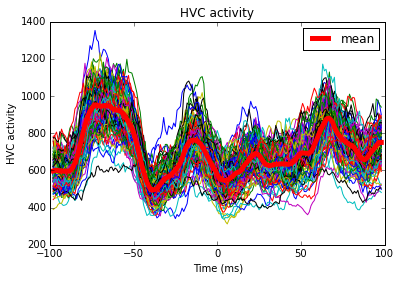

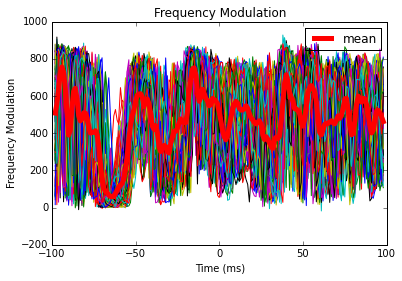

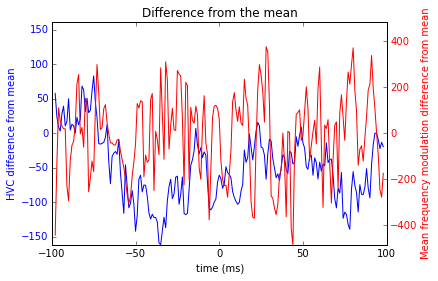

In [46]:
def deviation_from_mean(bird, clust, feature, plot=True):
    '''
    deviation_from_mean calculates the difference of each rendition 
    of a syllable and the mean across all syllables. it does the same 
    for the corresponding electrode recordings that preceed song by 50ms
    This works for any song feature
    
    arguments:
        bird = string, bird name
        clust = int, which syllable culster
        feature = string, which song feature
        plot = boolean, default True, plots the data
        
    returns:
        common_x, an array of the time values shared by all traces
        e_y_ms_mean, array of mean electrode activity across all renditions
        e_ave_y, array of arrays of all electrode traces
        feat_y, array of arrays of all song feature traces
        feat_ave_y, array of mean feature values across all renditions
    '''
    syl_data = pickle.load(open(syllable_table_path[bird], 'rb'))
    coefficients = [[],[]]
    # feature arrays
    feat_x = []
    feat_y = []
    e_x = []
    e_y = []
    
    for a, b, idx in clust_gen(bird, clust, feature, plot=False): # will need to make function which takes into accout the bird argument after testing
        temp_syl_data = syl_data[idx]
        temp_e_x, temp_e_y = get_elec_data(sp.io.loadmat(gen_path(bird, temp_syl_data['file_name'])), 
                                           temp_syl_data['start_on'], temp_syl_data['duration'], 
                                           electrode=good_electrodes[bird][0])
        if max(temp_e_y) < 1500 and max(temp_e_y) > 500: # selects against bad traces
            e_x.append(temp_e_x) 
            e_y.append(temp_e_y)
            feat_x.append(a)
            feat_y.append(b)

    shortest_feat_x = range(int(shortest_array(feat_x)[0] + 1), int(shortest_array(feat_x)[-1]))
    common_x = shortest_feat_x
    shortest_e_x = shortest_array(e_x)
    for idx in range(len(e_x)):
        feat_y[idx] = match_x(shortest_feat_x, feat_x[idx], feat_y[idx])
        e_y[idx] = match_x(shortest_e_x, e_x[idx], e_y[idx])
    
    time_bins = []
    for val in shortest_feat_x:
        time_bins.append(val - 0.5)
    time_bins.append(shortest_feat_x[-1] + 0.5)
    e_y_ms_mean = []
    for array in e_y:
        bin_means, bin_edges, binnumber = stats.binned_statistic(shortest_e_x, array, statistic='mean', bins=time_bins)
        e_y_ms_mean.append(bin_means)
    
    feat_ave_y = make_median_array(common_x, feat_y, average='mean')
    e_ave_y = make_median_array(common_x, e_y_ms_mean, average='mean')
    
    if plot:
        for idx in range(len(e_x)):
            plt.plot(common_x, e_y_ms_mean[idx])
        plt.plot(common_x, e_ave_y, linewidth=5, color='r', label='mean')
        plt.title('HVC activity')
        plt.xlabel('Time (ms)')
        plt.ylabel('HVC activity')
        plt.legend()
        plt.show()

        for idx in range(len(e_x)):
            plt.plot(shortest_feat_x, feat_y[idx])
        plt.plot(shortest_feat_x, feat_ave_y, linewidth=5, color='r', label='mean')
        plt.title(feature_name['caps'][feature])
        plt.xlabel('Time (ms)')
        plt.ylabel(feature_name['caps'][feature])
        plt.legend()
        plt.show()

        e_deviation = []
        for array in e_y_ms_mean:
            e_deviation.append(array - e_ave_y)
        
        feat_deviation = []
        for array in feat_y:
            feat_deviation.append(array - feat_ave_y)
        
        
        fig, e_ax = plt.subplots()
        e_ax.plot(common_x, e_deviation[0], 'b-')
        e_ax.set_xlabel('time (ms)')
        e_ax.set_ylabel('HVC difference from mean', color='b')
        largest_y_val = max(abs(e_deviation[0]))
        e_ax.set_ylim(-largest_y_val, largest_y_val)
        for tl in e_ax.get_yticklabels():
            tl.set_color('b')

        f_ax = e_ax.twinx()
        f_ax.plot(common_x, feat_deviation[0], 'r-')
        f_ax.set_ylabel('Mean '+feature_name['lower_case'][feature]+' difference from mean', color='r')
        largest_y_val = max(abs(feat_deviation[0]))
        f_ax.set_ylim(-largest_y_val, largest_y_val)
        for tl in f_ax.get_yticklabels():
            tl.set_color('r')
        e_ax.set_title('Difference from the mean')
        plt.show()
    
    return common_x, e_y_ms_mean, e_ave_y, feat_y, feat_ave_y
    
common_x, e_y_ms_mean, e_ave_y, feat_y, feat_ave_y = deviation_from_mean('blk161', 1, 'FM', plot=True)

#Save precessed data for further processing

The above code took 2-3 hours to execute on all the data. I therefore wanted to make a save point so that further processing wouldn't take too long. Pickle is a python function which allows the saving of python objects including dictionaries. Although it may not be the most efficient solution, or transferable to other programming langages it does suit my purpose well as it is very simple to use.

In [47]:
def save_processed_data(bird, cluster, feature):
    '''
    Saves the return values of deviation from the mean as a python dictionary in the pickle format.
    
    arguments:
        bird = string, bird name
        clust = int, which syllable culster
        feature = string, which song feature
        
    pickle dictionaries have the keys 'time', 'e', 'e mean', 'feat', 'feat mean'
    
    time, an array of the time values shared by all traces
    e mean, array of mean electrode activity across all renditions
    e, array of arrays of all electrode traces
    feat, array of arrays of all song feature traces
    feat mean, array of mean feature values across all renditions
    '''
    common_x, e_y_ms_mean, e_ave_y, feat_y, feat_ave_y = deviation_from_mean(bird, cluster, feature, plot=False)
    figure_data = {}
    figure_data['time'] = common_x
    figure_data['e'] = e_y_ms_mean
    figure_data['e mean'] = e_ave_y
    figure_data['feat'] = feat_y
    figure_data['feat mean'] = feat_ave_y
    pickle.dump(figure_data, open('C:\\Users\\abre049.UOA\\Documents\\data\\deviation from the mean data\\'+bird+'_'+str(cluster)+'_'+feature+'.p', 'wb'))

## the below code iterates through the data to save each syllable as a pickle file
# for bird in ['White293','Orange222']:
#     for clust in [4]:
#         for feature in ['amplitude',
#                             'entropy',
#                             'goodness',
#                             'pitch', 
#                             'mean_frequency',
#                             'FM']:
#             save_processed_data(bird, clust, feature)

In [93]:
# slope, intercept, r_value, p_value, std_err = stats.linregress(e_deviation[0], feat_deviation[0])
# print 'slope', slope
# print 'intercept', intercept
# print 'r_value', r_value
# print 'p_value', p_value
# print 'std_err', std_err
                
# plt.scatter(e_deviation[0], feat_deviation[0])
# plt.xlabel('HVC activity difference from mean')
# plt.ylabel('amplitude difference from mean')
# X_plot = np.linspace(min(e_deviation[0]),max(e_deviation[0]),10)
# plt.plot(X_plot, X_plot*slope + intercept)
# plt.show()

# e_means = [np.mean(array) for array in e_deviation]
# feat_means = [np.mean(array) for array in feat_deviation]
# slope, intercept, r_value, p_value, std_err = stats.linregress(e_means, feat_means)
# print 'slope', slope
# print 'intercept', intercept
# print 'r_value', r_value
# print 'p_value', p_value
# print 'std_err', std_err
# plt.scatter(e_means, feat_means)
# X_plot = np.linspace(min(e_means),max(e_means),10)
# plt.plot(X_plot, X_plot*slope + intercept)
# plt.show()

#Scattergrams of difference from the mean

The below code opens the saves (pickle) data and save plots of the scattergrams of difference from the mean for HVC activity and all song features. there are 96 plots across all birds, syllables and features. The plots include a line of best fit, pearsons R value and p value

In [49]:
def save_scatter_plots():
    '''
    reads the pickle files with processed data and saves scattergram images with line of best fit and pearsons R value and p value for all birds, syllables and features
    
    takes no arguments
    '''
    mypath = "C:\\Users\\abre049.UOA\\Documents\\data\\deviation from the mean data"
    blank = matplotlib.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                         visible=False)

    for (dirpath, dirnames, filenames) in walk(mypath):
        for file_name in filenames:
            cluster_data = pickle.load(open(dirpath+'\\'+file_name, 'rb'))
    #         print cluster_data.keys()
    #         plt.plot(cluster_data['time'], cluster_data['e'][0])
    #         plt.show()
    #         plt.plot(cluster_data['time'], cluster_data['feat'][0])
    #         plt.show()
            e_less_mean = []
            for trace in cluster_data['e']:
                e_less_mean.extend(trace-cluster_data['e mean'])
            feat_less_mean = []
            for trace in cluster_data['feat']:
                feat_less_mean.extend(trace - cluster_data['feat mean'])
    #         print len(feat_less_mean)
    #         print len(e_less_mean)
    #         plt.plot(feat_less_mean[:100])
    #         plt.show()

            slope, intercept, r_value, p_value, std_err = stats.linregress(e_less_mean, feat_less_mean,)
            print 'slope', slope
            print 'intercept', intercept
            print 'r_value', r_value
            print 'p_value', p_value
            print 'std_err', std_err

            r_value_2dp = '=' + str(np.around(r_value, decimals=2))
            if p_value < 0.0001:
                p_value_4dp = '<0.0001'
            else:
                p_value_4dp = '=' + str(np.around(p_value, decimals=4))

            plt.scatter(e_less_mean, feat_less_mean,)
            X_plot = np.linspace(min(e_less_mean),max(e_less_mean),10)
            plt.plot(X_plot, X_plot*slope + intercept, color='r', linewidth=5)
            x1,x2,y1,y2 = plt.axis()
            plt.axis((x1,x2+(x2-x1),y1,y2))
    #         plt.xlabel('HVC Activity (V X 10^-8, smoothed)') # Took out labels to conserve space. Will explain axis in figure key
    #         plt.ylabel('Mean '+ feature_name['caps'][feature])
            plt.legend([blank], ['R'+r_value_2dp+'\np'+p_value_4dp], prop={'size':28}, frameon=False, loc=7)
            save_file_name = "C:\\Users\\abre049.UOA\\Google Drive\\Work\\Medicine\\TI\\Elective\\Images\\Difference from mean\\"+file_name[:-2]+'.png'
            plt.savefig(save_file_name, bbox_inches='tight')
            plt.show()
            plt.close()

# save_scatter_plots()

#Replicate Day 2008 Figure 4

The following code prints the images (plots and spectrograms) required to replicate the Day 2008 figure 4. Day's analysis was at the motif level where as my analysis is at the syllable level.

A reader may note that at this point there is large amounts of cutting and pasting with modifications to the copied code. This is not best practise, and given more time I would have liked to make this code cleaner. However, time limitations shifted the focus from reuseable code to productive code.

1117.46 1442.721


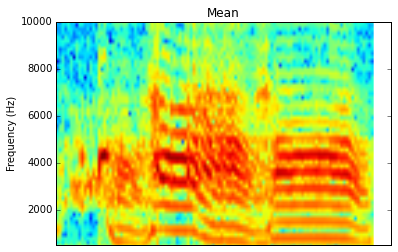

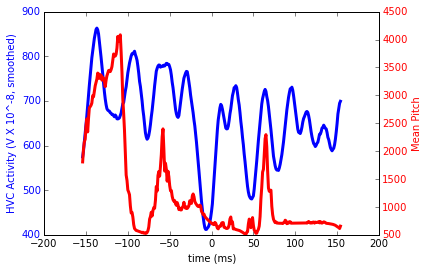

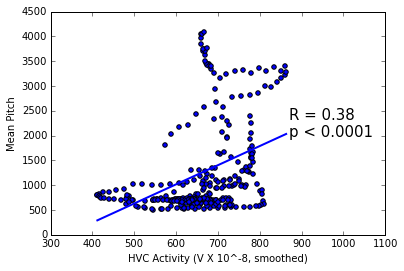

slope 3.86086861843
intercept -1299.09057028
r_value 0.380322731988
p_value 4.51188714468e-12
std_err 0.535841880166


In [50]:
def replicate_fig4_day2008(bird, clust, feature, appendix1=False):
    '''
    Replicates figure 4 from the Day 2008 paper.
    
    inputs
        bird, string of bird name
        clust, int of syllable cluster
        feature, string of song feature
        
    plots 3 graphs 1. spectorgram of syllable, 2. mean HVC and song feature traces,
    3. scattergram of two traces
    prints the results of linear regression between the two traces
    
    plots must be saved manually
    '''
    syl_data = pickle.load(open(syllable_table_path[bird], 'rb')) # load the syllable table
    coefficients = [[],[]]
    # feature arrays
    feat_x = []
    feat_y = []
    e_x = []
    e_y = []
    
    for a, b, idx in clust_gen(bird, clust, feature, plot=False): # extract the data for the cluster
        temp_syl_data = syl_data[idx] # raw_feature data
        temp_e_x, temp_e_y = get_elec_data(sp.io.loadmat(gen_path(bird, temp_syl_data['file_name'])), # electrode data extraction 
                                           temp_syl_data['start_on'], temp_syl_data['duration'], 
                                           electrode=good_electrodes[bird][0])
        if max(temp_e_y) < 1500 and max(temp_e_y) > 500: # selects against bad traces
            e_x.append(temp_e_x) 
            e_y.append(temp_e_y)
            feat_x.append(a)
            feat_y.append(b)

    shortest_feat_x = range(int(shortest_array(feat_x)[0] + 1), int(shortest_array(feat_x)[-1])) #find the shortest array
    common_x = shortest_feat_x # this becomes the common x values
    shortest_e_x = shortest_array(e_x)
    for idx in range(len(e_x)): #interpolate so the x values match
        feat_y[idx] = match_x(shortest_feat_x, feat_x[idx], feat_y[idx]) 
        e_y[idx] = match_x(shortest_e_x, e_x[idx], e_y[idx])
        
    time_bins = []
    for val in shortest_feat_x: # make 1 ms bins
        time_bins.append(val - 0.5)
    time_bins.append(shortest_feat_x[-1] + 0.5)
    e_y_ms_mean = []
    for array in e_y: # calculate the mean values for every 1 ms for each electrode
        bin_means, bin_edges, binnumber = stats.binned_statistic(shortest_e_x, array, statistic='mean', bins=time_bins)
        e_y_ms_mean.append(bin_means)
    

    
    mean_e_y = []
    mean_feat_y = []
    for idx in range(len(common_x)): # make one array for e and feat which is the mean of all traces means at each ms
        temp_e_bin = [val[idx] for val in e_y_ms_mean]
        temp_feat_bin = [val[idx] for val in feat_y]
        mean_e_y.append(np.mean(temp_e_bin))
        mean_feat_y.append(np.mean(temp_feat_bin))
        
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(mean_e_y, mean_feat_y)
    r_value_2dp = '= ' + str(np.around(r_value, decimals=2))
    if p_value < 0.0001:
        p_value_4dp = '< 0.0001'
    else:
        p_value_4dp = '= ' + str(np.around(p_value, decimals=4))

    blank = mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                     visible=False)
    
    if appendix1 == False:
#     specgram
        found_example = False
        for idx in range(len(syl_data[1:]) + 1): # find the syllables of the desired cluster
            if found_example:
                break
            if syl_data[idx]['cluster'] == clust:
                song_array = [val[0] for val in sp.io.loadmat(gen_path(bird, syl_data[idx]['file_name']))['sng']]
                print syl_data[idx]['start_on'], syl_data[idx]['start_on'] + syl_data[idx]['duration']
                cut_song = song_array[int(syl_data[idx]['start_on']*44.1): 
                                      int((syl_data[idx]['start_on'] + syl_data[idx]['duration'] + 10)*44.1)]
                plt.specgram(cut_song, Fs=sampling_freq)
                plt.title('Mean')
                plt.ylabel('Frequency (Hz)')
                frame1 = plt.gca()
                frame1.axes.get_xaxis().set_visible(False)
                x1,x2,y1,y2 = plt.axis()
                plt.axis((x1,x2,500,10000))
                plt.show()
                found_example = True
        
        fig, e_ax = plt.subplots()
        e_ax.plot(common_x, mean_e_y, 'b-', linewidth=3)
        e_ax.set_xlabel('time (ms)')
        e_ax.set_ylabel('HVC Activity (V X 10^-8, smoothed)', color='b')
        for tl in e_ax.get_yticklabels():
            tl.set_color('b')

        f_ax = e_ax.twinx()
        f_ax.plot(common_x, mean_feat_y, 'r-', linewidth=3)
        f_ax.set_ylabel('Mean '+feature_name['caps'][feature], color='r')
        for tl in f_ax.get_yticklabels():
            tl.set_color('r')
        plt.show()

        plt.scatter(mean_e_y, mean_feat_y)
        X_plot = np.linspace(min(mean_e_y), max(mean_e_y), 10)
        plt.plot(X_plot, X_plot*slope + intercept, linewidth=2)
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2+200,y1,y2))
        plt.xlabel('HVC Activity (V X 10^-8, smoothed)')
        plt.ylabel('Mean '+ feature_name['caps'][feature])
        plt.legend([blank], ['R '+r_value_2dp+'\np '+p_value_4dp], prop={'size':15}, frameon=False, loc=7)
        plt.show()

        print 'slope', slope
        print 'intercept', intercept
        print 'r_value', r_value
        print 'p_value', p_value
        print 'std_err', std_err
    else:
        plt.scatter(mean_e_y, mean_feat_y)
        X_plot = np.linspace(min(mean_e_y), max(mean_e_y), 10)
        plt.plot(X_plot, X_plot*slope + intercept, linewidth=2)
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2+200,y1,y2))
        plt.xlabel('HVC Activity (V X 10^-8, smoothed)')
        plt.ylabel('Mean '+ feature_name['caps'][feature])
        plt.legend([blank], ['R '+r_value_2dp+'\np '+p_value_4dp], prop={'size':15}, frameon=False, loc=7)
        save_file_name = "C:\\Users\\abre049.UOA\\Google Drive\\Work\\Medicine\\TI\\Elective\\Images\\appendix 1\\"+bird+'_'+str(clust)+'_'+feature+'.png'
        plt.savefig(save_file_name, bbox_inches='tight')
        plt.close()
        
        appendix_1_db = {'common_x':common_x,'e_y': mean_e_y,'feat_y': mean_feat_y,'slope': slope,'intercept': intercept,'r_value': r_value,'p_vaule': p_value,'str_err': std_err}
        pickle.dump(appendix_1_db, open("C:\\Users\\abre049.UOA\\Google Drive\\Work\\Medicine\\TI\\Elective\\Images\\appendix 1\\"+bird+'_'+str(clust)+'_'+feature+'.p', 'wb'))
        

#             scatter
#         variance
#             line
#             scatter

# replicate_fig4_day2008('blk161', 1, 'goodness')
replicate_fig4_day2008('blk161', 2, 'pitch')
# replicate_fig4_day2008('blk161', 3, 'amplitude')

In [51]:
def make_figure_2():
    '''
    calls the replicate_fig4_day2008 function for all the syllables for a feature in one bird
    '''
    for cluster in range(1,5):
        for feature in []:
            replicate_fig4_day2008('blk161', cluster, 'entropy')
    
# make_figure_2()

#Examples of each syllable for appendix
below is a hack of the replicate fig4 day2008 function. It will plot the specgram of each of the syllabes of all birds. It will also plot other graphs which are not needed. spec grams need to be saved by hand.

In [98]:
def save_syllable_example():
    '''
    used to generate the spectrograms of the syllables used in 
    '''
    for bird in ['White293']:
        for cluster in range(1, 5):
            replicate_fig4_day2008(bird, cluster, 'amplitude')
    
# save_syllable_example()

In [99]:
def make_appendix_1():
    for bird in ['White293']:
        for cluster in range(1, 5):
            for feature in ['amplitude',
                            'entropy',
                            'goodness',
                            'pitch', 
                            'mean_frequency',
                            'FM']:
                print bird, cluster, feature
                replicate_fig4_day2008(bird, cluster, feature, appendix1=True)

# make_appendix_1()

In [100]:
# import wave

# original_wd = os.getcwd()
# os.chdir('C:\\Users\\abre049.UOA\\Documents\\data\\Crandall 2007 e2 wav files\\blk161\\') #C:\\Users\\abre049.UOA\\Documents\\data\\Crandall 2007\\blk161\\sngblk1610307wtrigA23-Mar125009\\wavs\\
# test = wave.open('v0307t073839v2.wav')
# print test.getparams()
# os.chdir('C:\\Users\\abre049.UOA\\Google Drive\\Work\\Medicine\\TI\\Elective\\GITHUB\\AlexSandbox')
# print os.getcwd()

#nchannels, sampwidth, framerate, nframes, comptype, compname

#Write .wav files for all birds

Only Blk161 had wav file provided. I will create .wav file from the .mat files of all birds with python. I will use the raw data (as filters will be applied in SAP2011 and smoothed to 1 ms intervals)

Note that o222 had a currupt file, so was done seperately and that file was excluded. In order to unzip o222 I had to use 7zip rather than winzip.

In [101]:
def make_wav_file(data, bird, file_name):
    '''
    Takes a loaded .mat file and generates a .wav file from the raw audio data named audio.wav in the working directory
    '''
    original_wd = os.getcwd()
    os.chdir('C:\\Users\\abre049.UOA\\Documents\\data\\Crandall 2007 wav files\\' + str(bird))
    song_name = 'v' + file_name[10:14] + 't' + file_name[3:9] + file_name[14:-3] + 'wav'
    sp.io.wavfile.write(song_name, sampling_freq, data)
    os.chdir(original_wd)
    
# for bird in song_locs.keys():
#     if bird != 'dir':
#         for file_names in song_locs[bird].values():
#             for file_name in file_names:
#                 song_array = sp.io.loadmat(gen_path(bird, file_name))['e2'][0]
#                 make_wav_file(song_array, bird, file_name)

# for file_names in song_locs['Orange222'].values():
#     for file_name in file_names:
#         if file_name != 'sng174734_0417v6.mat': #NB the exclusion of the currupt file
# #             print gen_path('Orange222', file_name)
#             song_array = sp.io.loadmat(gen_path('Orange222', file_name))['sng']
#             make_wav_file(song_array, 'Orange222', file_name)

#Effects of different delay times on song features

previously I had been using a default delay of 50 ms between HVC activity and audio recordings. I wondered what the correlations between the two would be like at different delays.

I manually exctracted 15 motifs and saved their song feature data with a function not in this notebook.

I then ran the same correlations between the mean song feature and the mean hvc activity at different time delay of audio reletive to HVC. 0 - 70 ms with 5ms steps.

630.567 1415.782


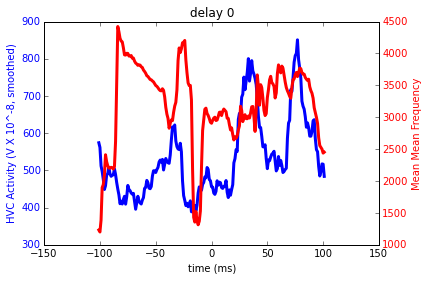

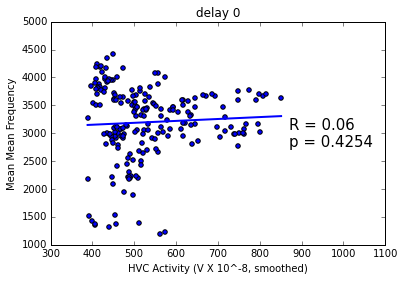

slope 0.3431373416
intercept 3014.40885856
r_value 0.056243276147
p_value 0.425435896065
std_err 0.429646572394
(0.056243276146989332, 0.42543589606487131)
630.567 1415.782


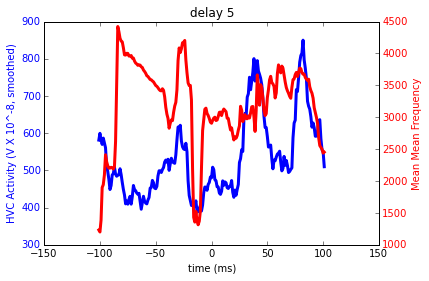

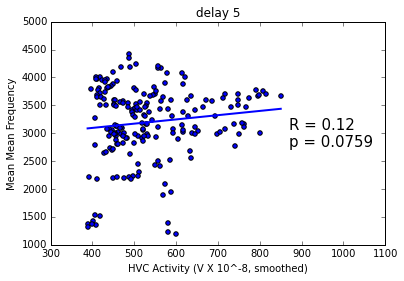

slope 0.760910637507
intercept 2790.44766382
r_value 0.124874757351
p_value 0.0758715421453
std_err 0.426430402827
(0.12487475735060122, 0.075871542145285853)
630.567 1415.782


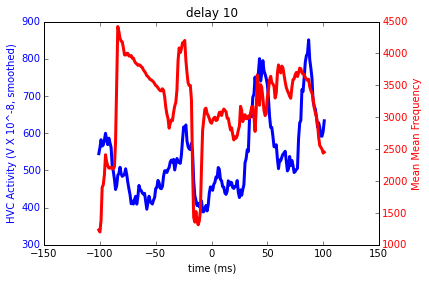

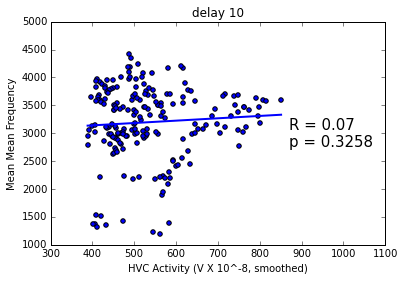

slope 0.423072374742
intercept 2971.01347449
r_value 0.069310695519
p_value 0.325799654751
std_err 0.429507448239
(0.069310695518960505, 0.32579965475141492)
630.567 1415.782


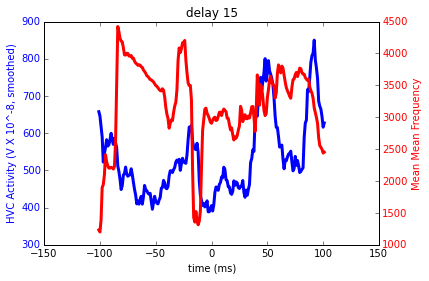

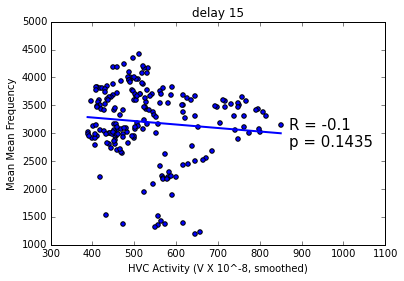

slope -0.627625053835
intercept 3532.41619148
r_value -0.103027190559
p_value 0.143537927732
std_err 0.427398638062
(-0.10302719055901817, 0.1435379277323246)
630.567 1415.782


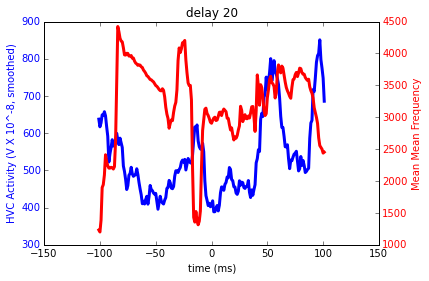

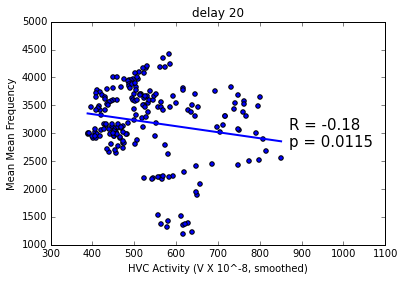

slope -1.08043742395
intercept 3774.12751354
r_value -0.176979136781
p_value 0.0115381016033
std_err 0.423808167572
(-0.17697913678135421, 0.011538101603311169)
630.567 1415.782


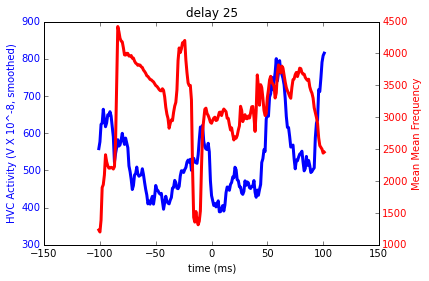

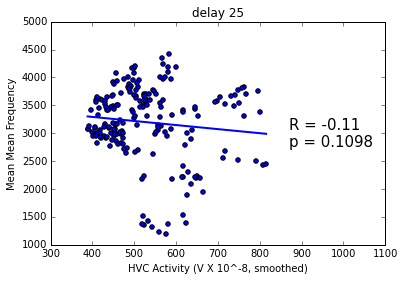

slope -0.72971509007
intercept 3583.90645096
r_value -0.112569202458
p_value 0.109810204479
std_err 0.454324831915
(-0.1125692024581405, 0.10981020447874915)
630.567 1415.782


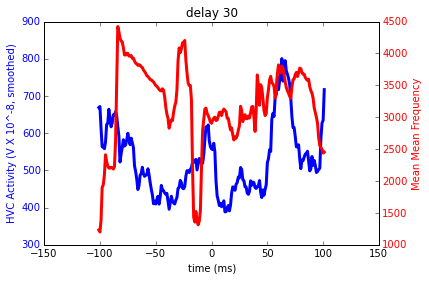

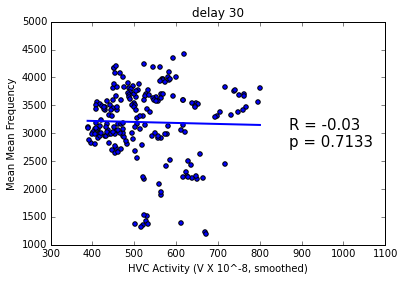

slope -0.179926122899
intercept 3291.74634227
r_value -0.0259404040313
p_value 0.713340508569
std_err 0.489072550426
(-0.025940404031273349, 0.71334050856873332)
630.567 1415.782


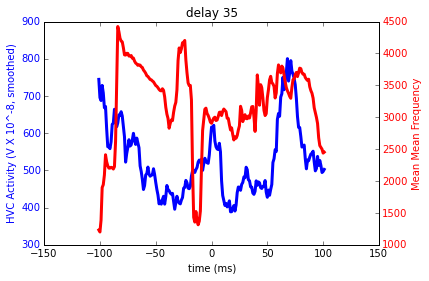

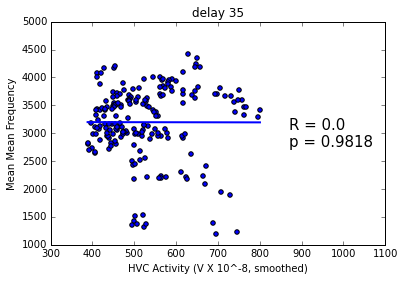

slope -0.0108688168612
intercept 3202.81443972
r_value -0.00161490298474
p_value 0.981756557213
std_err 0.474719682766
(-0.0016149029847413003, 0.981756557213188)
630.567 1415.782


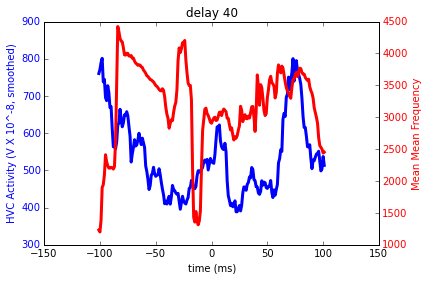

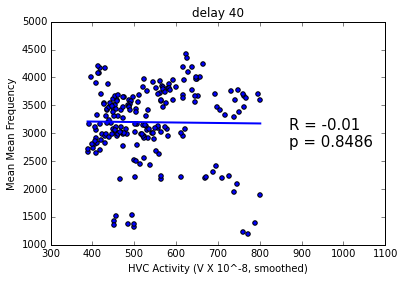

slope -0.0845862698221
intercept 3242.33700059
r_value -0.0134772127345
p_value 0.848648101872
std_err 0.442651882836
(-0.013477212734461124, 0.84864810187216533)
630.567 1415.782


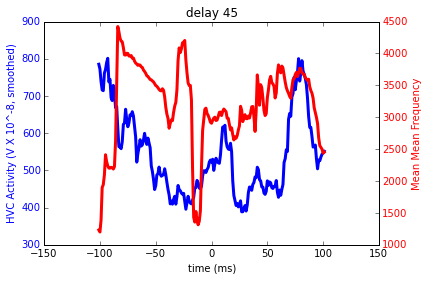

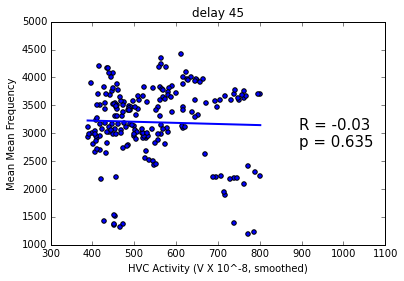

slope -0.200772087804
intercept 3305.65075946
r_value -0.0335146007086
p_value 0.635004914619
std_err 0.422305963088
(-0.033514600708594931, 0.63500491461943931)
630.567 1415.782


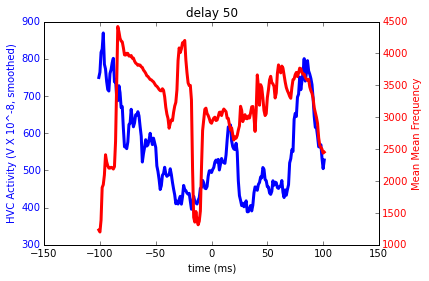

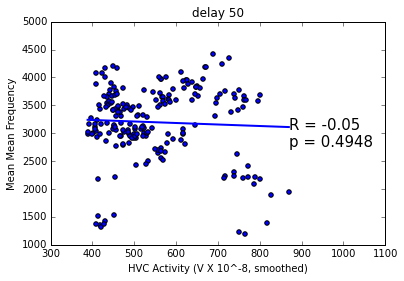

slope -0.269806424062
intercept 3344.74817137
r_value -0.0481869720704
p_value 0.494786441224
std_err 0.394475305451
(-0.048186972070448246, 0.49478644122412063)
630.567 1415.782


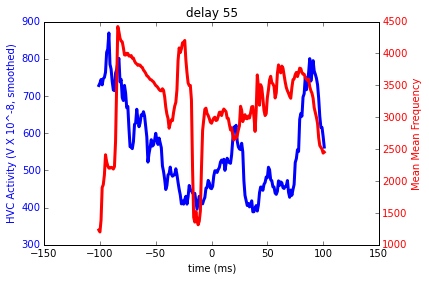

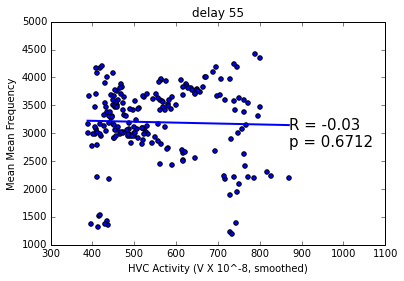

slope -0.162868222808
intercept 3287.00607116
r_value -0.0299720165554
p_value 0.67120566389
std_err 0.383113282472
(-0.029972016555446936, 0.67120566388951186)
630.567 1415.782


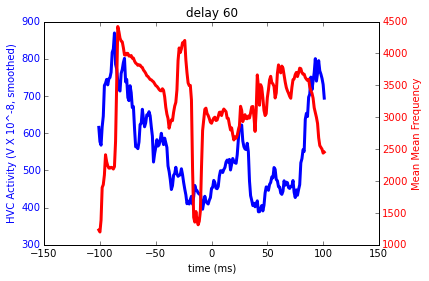

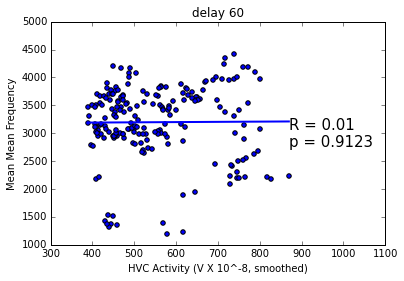

slope 0.0422628611837
intercept 3173.7324361
r_value 0.00777726360165
p_value 0.912309169455
std_err 0.383284196393
(0.0077772636016484277, 0.91230916945547647)
630.567 1415.782


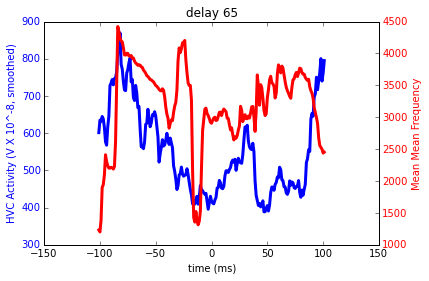

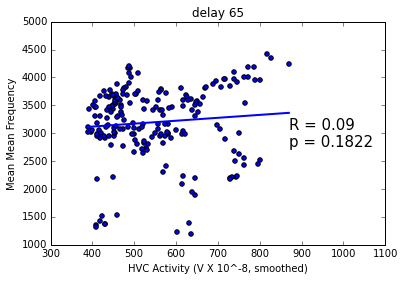

slope 0.524272522435
intercept 2908.99108966
r_value 0.0940058615285
p_value 0.182183324439
std_err 0.391630630979
(0.09400586152845361, 0.1821833244385973)
630.567 1415.782


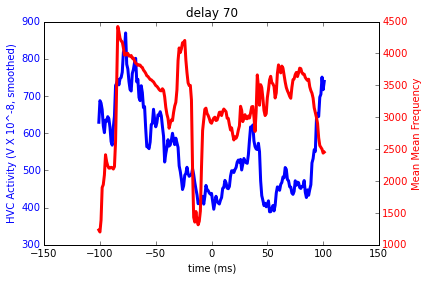

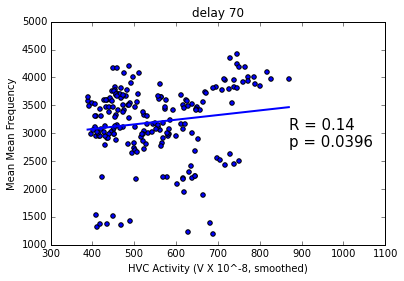

slope 0.835271063929
intercept 2740.48183456
r_value 0.144564560809
p_value 0.0396063439726
std_err 0.403256459864
(0.14456456080943267, 0.039606343972550938)


In [53]:
def different_delays(feature, delay):
    '''
    plots scattergrams with line of best fit, correlation coefficient 
    and p values for specified feature mean and hvc actiivty mean for the specified time delay
    
    input
        feature, string of song feature that you want to plot
        delay, int of the delay of audio recording relative to neural recording.
    '''
    bird = 'blk161'
    clust = 1
    syl_data = pickle.load(open('C:\\Users\\abre049.UOA\\Documents\\data\\blk161 motif\\blk161.p', 'rb')) # load the syllable table
    coefficients = [[],[]]
    # feature arrays
    feat_x = []
    feat_y = []
    e_x = []
    e_y = []
    
    for a, b, idx in clust_gen(bird, clust, feature, plot=False): # extract the data for the cluster
        temp_syl_data = syl_data[idx] # raw_feature data
        if temp_syl_data['file_name'] == '1':
            break
        temp_e_x, temp_e_y = get_elec_data(sp.io.loadmat(gen_path(bird, temp_syl_data['file_name'])), # electrode data extraction 
                                           temp_syl_data['start_on'], temp_syl_data['duration'], 
                                           electrode=good_electrodes[bird][0], offset=delay)
        if max(temp_e_y) < 1500 and max(temp_e_y) > 500: # selects against bad traces
            e_x.append(temp_e_x) 
            e_y.append(temp_e_y)
            feat_x.append(a)
            feat_y.append(b)

    shortest_feat_x = range(int(shortest_array(feat_x)[0] + 1), int(shortest_array(feat_x)[-1])) #find the shortest array
    common_x = shortest_feat_x # this becomes the common x values
    shortest_e_x = shortest_array(e_x)
    for idx in range(len(e_x)): #interpolate so the x values match
        feat_y[idx] = match_x(shortest_feat_x, feat_x[idx], feat_y[idx]) 
        e_y[idx] = match_x(shortest_e_x, e_x[idx], e_y[idx])

    time_bins = []
    for val in shortest_feat_x: # make 1 ms bins
        time_bins.append(val - 0.5)
    time_bins.append(shortest_feat_x[-1] + 0.5)
    e_y_ms_mean = []
    for array in e_y: # calculate the mean values for every 1 ms for each electrode
        bin_means, bin_edges, binnumber = stats.binned_statistic(shortest_e_x, array, statistic='mean', bins=time_bins)
        e_y_ms_mean.append(bin_means)



    mean_e_y = []
    mean_feat_y = []
    for idx in range(len(common_x)): # make one array for e and feat which is the mean of all traces means at each ms
        temp_e_bin = [val[idx] for val in e_y_ms_mean]
        temp_feat_bin = [val[idx] for val in feat_y]
        mean_e_y.append(np.mean(temp_e_bin))
        mean_feat_y.append(np.mean(temp_feat_bin))


    slope, intercept, r_value, p_value, std_err = stats.linregress(mean_e_y, mean_feat_y)
    r_value_2dp = '= ' + str(np.around(r_value, decimals=2))
    if p_value < 0.0001:
        p_value_4dp = '< 0.0001'
    else:
        p_value_4dp = '= ' + str(np.around(p_value, decimals=4))

    blank = mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                     visible=False)
    found_example = False
    for idx in range(len(syl_data[1:]) + 1): # find the syllables of the desired cluster
        if found_example:
            break
        if syl_data[idx]['cluster'] == clust:
            song_array = [val[0] for val in sp.io.loadmat(gen_path(bird, syl_data[idx]['file_name']))['sng']]
            print syl_data[idx]['start_on'], syl_data[idx]['start_on'] + syl_data[idx]['duration']
#             cut_song = song_array[int(syl_data[idx]['start_on']*44.1): 
#                                   int((syl_data[idx]['start_on'] + syl_data[idx]['duration'] + 10)*44.1)]
#             plt.specgram(cut_song, Fs=sampling_freq)
#             plt.title('Mean')
#             plt.ylabel('Frequency (Hz)')
#             frame1 = plt.gca()
#             frame1.axes.get_xaxis().set_visible(False)
#             x1,x2,y1,y2 = plt.axis()
#             plt.axis((x1,x2,500,10000))
#             plt.show()
            found_example = True
        
        fig, e_ax = plt.subplots()
        e_ax.plot(common_x, mean_e_y, 'b-', linewidth=3)
        e_ax.set_xlabel('time (ms)')
        e_ax.set_ylabel('HVC Activity (V X 10^-8, smoothed)', color='b')
        e_ax.set_title('delay '+str(delay))
        for tl in e_ax.get_yticklabels():
            tl.set_color('b')

        f_ax = e_ax.twinx()
        f_ax.plot(common_x, mean_feat_y, 'r-', linewidth=3)
        f_ax.set_ylabel('Mean '+feature_name['caps'][feature], color='r')
        for tl in f_ax.get_yticklabels():
            tl.set_color('r')
        plt.show()

        plt.scatter(mean_e_y, mean_feat_y)
        X_plot = np.linspace(min(mean_e_y), max(mean_e_y), 10)
        plt.plot(X_plot, X_plot*slope + intercept, linewidth=2)
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2+200,y1,y2))
        plt.xlabel('HVC Activity (V X 10^-8, smoothed)')
        plt.ylabel('Mean '+ feature_name['caps'][feature])
        plt.legend([blank], ['R '+r_value_2dp+'\np '+p_value_4dp], prop={'size':15}, frameon=False, loc=7)
        plt.title('delay '+str(delay))
        plt.show()

        print 'slope', slope
        print 'intercept', intercept
        print 'r_value', r_value
        print 'p_value', p_value
        print 'std_err', std_err
    return r_value, p_value 
    
# different_delays('amplitude', 50)

for feat in ['mean_frequency']:
    for delay in [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]:
        print different_delays(feat, delay)